In [2]:
from pathlib import Path
import mlflow
import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from datamodules import BETHDataModule

In [3]:
tracking_uri = "http://haimserver:5000/"
experiment_name = "beth_anomaly_detection"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name=experiment_name)
mlflow.autolog()
pl_logger = MLFlowLogger(experiment_name, tracking_uri=tracking_uri)

2024/02/25 15:10:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/25 15:10:11 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2024/02/25 15:10:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.


In [29]:
input_directory = Path("data/np_arrays")

X_train = np.load(input_directory / "X_train.npy", allow_pickle=True).astype(
    np.float32
)
y_train = np.load(input_directory / "y_train.npy", allow_pickle=True).astype(
    np.float32
)
X_column_names = np.load(
    input_directory / "X_column_names.npy", allow_pickle=True
)

X_val = np.load(input_directory / "X_val.npy", allow_pickle=True).astype(
    np.float32
)
y_val = np.load(input_directory / "y_val.npy", allow_pickle=True).astype(
    np.float32
)

X_test = np.load(input_directory / "X_test.npy", allow_pickle=True).astype(
    np.float32
)
y_test = np.load(input_directory / "y_test.npy", allow_pickle=True).astype(
    np.float32
)

In [22]:
X_train[:, :-30].shape

(763144, 10)

In [24]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

In [25]:
X_train.shape

(763144, 40)

In [27]:
X_train[:, :-30].shape

(763144, 10)

2024/02/25 15:20:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fea7242e4b22485f91c652aa1bf7e777', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/25 15:20:07 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/02/25 15:20:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


<Axes: xlabel='PCA1', ylabel='PCA2'>

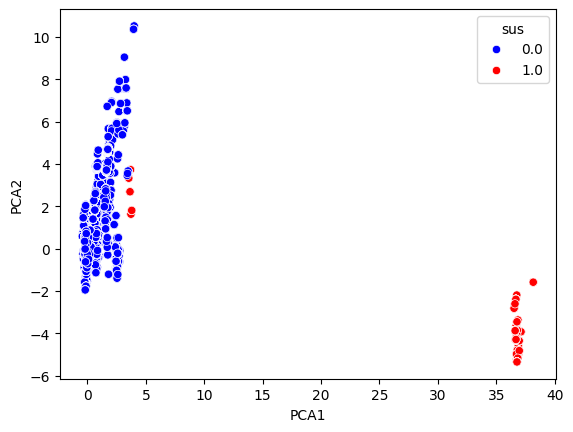

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import pandas as pd
import seaborn as sns

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_train[:, :])

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data={
        "PCA1": pca_result[:, 0],
        "PCA2": pca_result[:, 1],
        "sus": y_train,
    }
)

# Plot the scatterplot
sns.scatterplot(
    x="PCA1", y="PCA2", hue="sus", data=pca_df, palette={1: "red", 0: "blue"}
)

In [ ]:
%%writefile ann_tuner.py
import ast
import re
from pathlib import Path
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from gensim.models import Word2Vec
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger, TensorBoardLogger
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from torchmetrics import AUROC
from sklearn.preprocessing import StandardScaler

from datamodules import BETHDataModule
from models.ann import ANN

tracking_uri = "http://127.0.0.1:5000/"
experiment_name = "beth_anomaly_detection"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name=experiment_name)
mlflow.autolog()
pl_logger = MLFlowLogger(experiment_name, tracking_uri=tracking_uri)

input_directory = Path("data/np_arrays")

X_train = np.load(input_directory / "X_train.npy", allow_pickle=True).astype(
    np.float32
)
y_train = np.load(input_directory / "y_train.npy", allow_pickle=True).astype(
    np.float32
)
X_column_names = np.load(
    input_directory / "X_column_names.npy", allow_pickle=True
)

X_val = np.load(input_directory / "X_val.npy", allow_pickle=True).astype(
    np.float32
)
y_val = np.load(input_directory / "y_val.npy", allow_pickle=True).astype(
    np.float32
)

X_test = np.load(input_directory / "X_test.npy", allow_pickle=True).astype(
    np.float32
)
y_test = np.load(input_directory / "y_test.npy", allow_pickle=True).astype(
    np.float32
)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 216])
    batch_size = trial.suggest_categorical(
        "batch_size", [64, 128, 216, 512, 1024]
    )
    learning_rate = trial.suggest_loguniform("learning_rate", 3e-5, 3e-3)
    model = ANN(40, hidden_dim, 1, learning_rate=learning_rate)

    pl_logger = MLFlowLogger(experiment_name, tracking_uri=tracking_uri)
    datamodule = BETHDataModule(
        X_train,
        y_train,
        X_val,
        y_val,
        batch_size=batch_size,
    )
    trainer = pl.Trainer(
        logger=pl_logger,
        fast_dev_run=False,
        max_epochs=75,
        accelerator="gpu",
        devices=1,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                min_delta=0.00001,
                patience=5,
                verbose=True,
                mode="min",
            )
        ],
    )
    hyperparameters = dict(
        hidden_dim=hidden_dim,
        batch_size=batch_size,
        learning_rate=learning_rate,
    )
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=datamodule)

    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=60 * 60 * 8)

print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

In [ ]:
hidden_dim = 64
batch_size = 512
learning_rate = 0.00010514959005327053

datamodule = BETHDataModule(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    batch_size=batch_size,
    num_workers=2,
)
model = ANN(60, hidden_dim, 1, learning_rate=learning_rate)

trainer = pl.Trainer(
    logger=pl_logger,
    fast_dev_run=False,
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            min_delta=0.00001,
            patience=5,
            verbose=True,
            mode="min",
        )
    ],
)
hyperparameters = dict(
    hidden_dim=hidden_dim,
    batch_size=batch_size,
    learning_rate=learning_rate,
)
trainer.logger.log_hyperparams(hyperparameters)
trainer.fit(model, datamodule=datamodule)

In [ ]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F

from models.vae import VAE

In [70]:
%%writefile vae_tuner.py

tracking_uri = "http://127.0.0.1:5000/"
experiment_name = "beth_anomaly_detection"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name=experiment_name)
mlflow.autolog()
pl_logger = MLFlowLogger(experiment_name, tracking_uri=tracking_uri)

input_directory = Path("data/np_arrays")

X_train = np.load(input_directory / "X_train.npy", allow_pickle=True).astype(
    np.float32
)
y_train = np.load(input_directory / "y_train.npy", allow_pickle=True).astype(
    np.float32
)
X_column_names = np.load(
    input_directory / "X_column_names.npy", allow_pickle=True
)

X_val = np.load(input_directory / "X_val.npy", allow_pickle=True).astype(
    np.float32
)
y_val = np.load(input_directory / "y_val.npy", allow_pickle=True).astype(
    np.float32
)

X_test = np.load(input_directory / "X_test.npy", allow_pickle=True).astype(
    np.float32
)
y_test = np.load(input_directory / "y_test.npy", allow_pickle=True).astype(
    np.float32
)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)




class VAE(pl.LightningModule):
    def __init__(
        self,
        input_height=40,
        latent_dim=128,
        enc_out_dim=40,
    ):
        super().__init__()
        self.input_height = input_height
        self.latent_dim = latent_dim
        self.enc_out_dim = enc_out_dim

        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(self.input_height, self.latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.latent_dim, self.enc_out_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.latent_dim, self.input_height),
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-6)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=-1)

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(
            torch.zeros_like(mu), torch.ones_like(std)
        )
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = log_qzx - log_pz
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):

        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)

        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = kl - recon_loss
        elbo = elbo.mean()

        self.log_dict(
            {
                "elbo": elbo,
                "kl": kl.mean(),
                "recon_loss": recon_loss.mean(),
                "reconstruction": recon_loss.mean(),
                "kl": kl.mean(),
            }
        )

        return elbo


def objective(trial):
    latent_dim_choices = [2**i for i in range(7, 11)]
    latent_dim = trial.suggest_categorical("latent_dim", latent_dim_choices)
    batch_size_choices = [2**i for i in range(11, 14)]
    batch_size = trial.suggest_categorical("batch_size", batch_size_choices)

    datamodule = BETHDataModule(
        X_train,
        y_train,
        X_val,
        y_val,
        batch_size=batch_size,
    )
    model = VAE(input_height=40, latent_dim=latent_dim, enc_out_dim=40)
    trainer = pl.Trainer(
        logger=MLFlowLogger(experiment_name, tracking_uri=tracking_uri),
        fast_dev_run=False,
        max_epochs=50,
        accelerator="gpu",
        callbacks=[
            EarlyStopping(
                monitor="elbo",
                min_delta=0.00001,
                patience=10,
                verbose=True,
                mode="min",
            )
        ],
        devices=1,
    )
    hyperparameters = dict(
        batch_size=batch_size,§
        enc_out_dim=40,
        latent_dim=latent_dim,
        input_height=40,
    )
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=datamodule)

    val_loss = trainer.callback_metrics["elbo"].item()
    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5, timeout=60 * 60 * 8)

print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Writing vae_tuner.py


In [5]:

class VAE(pl.LightningModule):
    def __init__(
        self,
        input_height=40,
        latent_dim=128,
        enc_out_dim=40,
    ):
        super().__init__()
        self.input_height = input_height
        self.latent_dim = latent_dim
        self.enc_out_dim = enc_out_dim

        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(self.input_height, self.latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.latent_dim, self.enc_out_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.latent_dim, self.input_height),
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-6)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=-1)

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(
            torch.zeros_like(mu), torch.ones_like(std)
        )
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = log_qzx - log_pz
        kl = kl.sum(-1)
        return kl

    def load_model(self, path):
        return torch.load(path, map_location="cuda:0")
    

    def training_step(self, batch, batch_idx):

        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)

        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = kl - recon_loss
        elbo = elbo.mean()

        self.log_dict(
            {
                "elbo": elbo,
                "kl": kl.mean(),
                "recon_loss": recon_loss.mean(),
                "reconstruction": recon_loss.mean(),
                "kl": kl.mean(),
            }
        )

        return elbo

In [ ]:
!pip install icecream
from icecream import ic

In [69]:
[2**i for i in range(11, 14)] 

[2048, 4096, 8192]

In [6]:
checkpoint_path = "/home/haim/code/mlflow/mlartifacts/953044160103745260/50764ebee09949108326197d6672d422/artifacts/model/data/model.pth"

In [8]:
import torch.nn as nn 
model = VAE(40, 512, 40)
model.load_model(checkpoint_path)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=40, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=40, bias=True)
  )
  (fc_mu): Linear(in_features=40, out_features=512, bias=True)
  (fc_var): Linear(in_features=40, out_features=512, bias=True)
)

In [9]:
mus = []
vars = []
for sample in X_train:
    encoded = model.encoder(torch.Tensor(sample))
    mu, var = model.fc_mu(encoded), model.fc_var(encoded)
    mus.append(mu.detach().numpy())
    vars.append(mu.detach().numpy())
train_stats = np.hstack([np.array(mus), np.array(vars)])

In [10]:
mus = []
vars = []
for sample in X_val:
    encoded = model.encoder(torch.Tensor(sample))
    mu, var = model.fc_mu(encoded), model.fc_var(encoded)
    mus.append(mu.detach().numpy())
    vars.append(mu.detach().numpy())
val_stats = np.hstack([np.array(mus), np.array(vars)])

In [11]:
mus = []
vars = []
for sample in X_test:
    encoded = model.encoder(torch.Tensor(sample))
    mu, var = model.fc_mu(encoded), model.fc_var(encoded)
    mus.append(mu.detach().numpy())
    vars.append(mu.detach().numpy())
test_stats = np.hstack([np.array(mus), np.array(vars)])

In [12]:
def anomaly_results_to_binary(y: np.array) -> np.array:
    """
    Transforms an sklearn anomaly detection results format {-1, 0, 1} to
    binary format {0, 1}, where inliers are 0 and ouitliers are 1.
    Args:
        y (np.array): Array of predictions
    
    Returns:
        np.array: Same array, transformed so that 1 is outlier
    """
    y[y == 1] = 0  # inliers
    y[y == -1] = 1  # outliers
    return y


class DoSE_SVM:
    def __init__(self, X):
        self.pca = PCA(whiten=True, random_state=1337).fit(X)
        self.clf = SGDOneClassSVM(random_state=1337).fit(
            self.pca.transform(X)
        )

    def detect_outliers(self, test_summary_stats):
        return self.clf.predict(self.pca.transform(test_summary_stats)) == -1

In [13]:
with mlflow.start_run() as run:
    vae_dose_svm_model = DoSE_SVM(train_stats)
    
    y_hat = vae_dose_svm_model.detect_outliers(val_stats)
    auroc = roc_auc_score(y_val, y_hat)
    mlflow.log_metric("val_auroc", auroc)
    print("val auroc:", auroc)
    
    y_hat = vae_dose_svm_model.detect_outliers(test_stats)
    auroc = roc_auc_score(y_test, y_hat)
    mlflow.log_metric("test_auroc", auroc)
    print("test_auroc", auroc)
    

: 